In [1]:
import findspark as fs

import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

print(sys.executable)
print(sys.path)
print(sys.version)

import photutils
from photutils import detect_threshold
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D

#from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import time

import shutil
from math import pi, log, sqrt

import warnings
warnings.filterwarnings("ignore")

/home/s2494876/miniconda3/envs/sddm/bin/python
['/home/s2494876/miniconda3/envs/sddm/lib/python36.zip', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/lib-dynload', '', '/home/s2494876/.local/lib/python3.6/site-packages', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/site-packages', '/home/s2494876/.local/lib/python3.6/site-packages/IPython/extensions', '/home/s2494876/.ipython']
3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]


In [2]:
try:
    sc = SparkContext(appName="SDDM") #, master='spark://fs.dslc.liacs.nl:7078')
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

In [3]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"

In [4]:
# Take a look at the data in a .fits file
hdul = fits.open(mosaic_path + "P244+48_mosaic-blanked.fits")
data = hdul[0].data # The intensity data
print(hdul[0].__dict__)

{'_header_str': None, '_file': <astropy.io.fits.file._File <_io.FileIO name='/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P244+48_mosaic-blanked.fits' mode='rb' closefd=True>>, '_buffer': None, '_header_offset': 0, '_data_offset': 2880, '_data_size': 641681280, '_data_replaced': False, '_data_needs_rescale': False, '_new': False, '_output_checksum': False, '_checksum': None, '_checksum_valid': None, '_datasum': None, '_datasum_valid': None, '_do_not_scale_image_data': False, '_uint': True, '_scale_back': None, '_bzero': 0, '_bscale': 1, '_axes': [8956, 8956], '_bitpix': -64, '_gcount': 1, '_pcount': 0, '_blank': None, '_orig_bitpix': -64, '_orig_blank': None, '_orig_bzero': 0, '_orig_bscale': 1, '_modified': False, '_header': SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions             

In [5]:
def mosaic(file):
    hdul = fits.open(file)
    # data = hdul[0].data # The intensity data
    conv = hdul[0]._header["BMAJ"] # Should be 1/4 * BMAJ
    
    x = hdul[0]._header['NAXIS1']
    y = hdul[0]._header['NAXIS2']
    center = (x/2, y/2)

    # finite_area = np.sum(np.isfinite(data))
    # radius = np.sqrt(finite_area/pi) * conv
    radius = (max(x, y) / 2) * conv
    
    w = WCS(hdul[0].header)
    ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)
    
    return np.array((radius, ra, dec))

In [6]:
fits_files = [mosaic_path + f for f in os.listdir(mosaic_path)]
random.shuffle(fits_files)
file_paths = sc.parallelize(fits_files, 8) # , len(fits_files)
file_paths.collect()

['/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P213+57_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P152+45_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P236+55_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P142+50_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P140+60_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P141+47_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P210+52_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P4Hetdex16_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P142+42_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e96

In [7]:
test = file_paths.map(lambda fits: (mosaic(fits)))
info = test.collect()

In [8]:
type(info)
info[0]

array([  8.11333333, 213.04822555,  57.45111666])

In [9]:
overlap_dict = {k.split('/')[-1]: [] for k in fits_files}

for i, f1 in enumerate(fits_files):
    f1 = f1.split('/')[-1]
    for j, f2 in enumerate(fits_files):
        if j > i:
            f2 = f2.split('/')[-1]
            offset = np.array((info[i][1] - info[j][1], info[i][2] - info[j][2]))
            distance = np.sqrt(np.sum(np.power(offset, 2)))
            radius = info[i][0] * (3/8) + info[j][0] * (3/8)
            if distance <= radius:
                overlap_dict[f1].append(f2)
                overlap_dict[f2].append(f1)

In [10]:
with open(os.path.join('overlap_dict.csv'), 'w') as outfile:
    outfile.write('fitsfile,center_ra,center_dec,radius,overlaps')
    for i, fi in enumerate(fits_files):
        fi = fi.split('/')[-1]
        # print(len(np.unique(overlap_dict[fi])))
        outfile.write('\n{},{},{},{},{}'.format(fi, info[i][1], info[i][2], info[i][0]/4, ';'.join(np.unique(overlap_dict[fi]))))


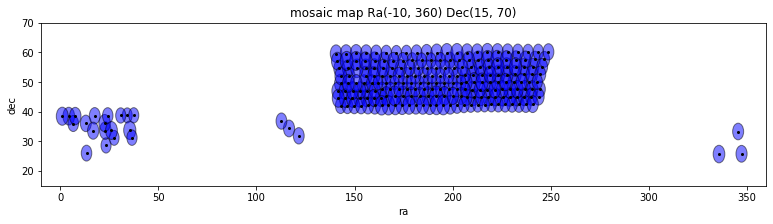

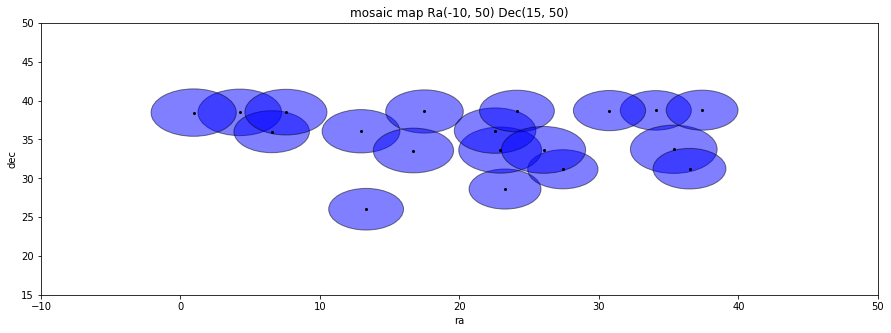

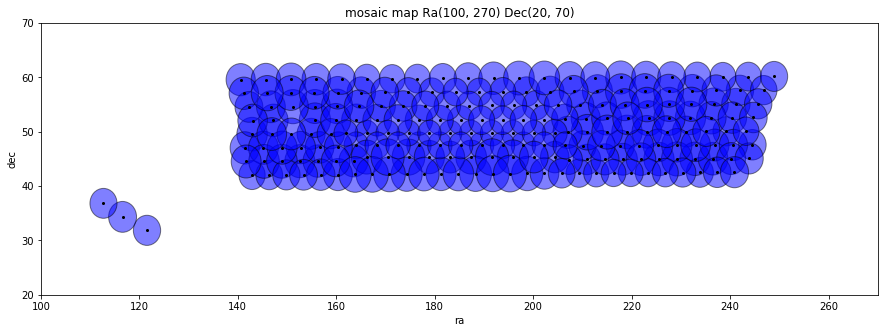

In [11]:
def map_mosaic(info, size=(15, 2), Ra=(-10, 360), Dec=(15, 70)):
    minRa, maxRa = Ra
    minDec, maxDec = Dec
    
    fig, ax = plt.subplots(figsize=size)
    for inf in info:
        ra = inf[1]
        dec = inf[2]
        if (ra >= minRa and ra <= maxRa) and (dec >= minDec and dec <= maxDec):
            ax.add_artist(plt.Circle((ra, dec), inf[0] * (3/8), edgecolor='black', alpha=0.5, facecolor='blue'))
            ax.plot(ra, dec, 'o', markersize=2, color='black')

    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('mosaic map Ra({}, {}) Dec({}, {})'.format(minRa, maxRa, minDec, maxDec))
    plt.xlim(minRa, maxRa)
    plt.ylim(minDec, maxDec)


map_mosaic(info, (13, 3))
map_mosaic(info, (15, 5), (-10, 50), (15, 50))
map_mosaic(info, (15, 5), (100, 270), (20, 70))

In [82]:
from shapely.geometry import asPolygon

x, y = np.where(np.isfinite(data) == 1)
print(y)
poly_arr = np.stack((x, y), axis=-1)

print(poly_arr)

pa = asPolygon(poly_arr)


[5338 5339 5340 ... 4570 4571 4572]
[[  84 5338]
 [  84 5339]
 [  84 5340]
 ...
 [8955 4570]
 [8955 4571]
 [8955 4572]]


In [ ]:
plt.plot(poly_arr)

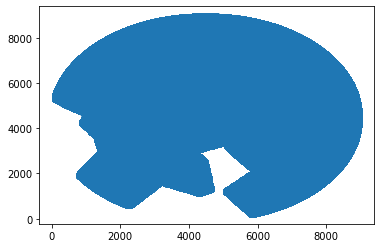

In [85]:
plt.scatter(poly_arr[:,0], poly_arr[:,1])

In [ ]:
np.where(np.isfinite(data[0]) == 1)

# Something

In [53]:
def calc_ellipse(file):
    hdul = fits.open(file)
    data = hdul[0].data # The intensity data
    conv = hdul[0]._header["BMAJ"]
        
    x = hdul[0]._header['NAXIS1']
    y = hdul[0]._header['NAXIS2']
    center = (x/2, y/2)

    finite_area = np.sum(np.isfinite(data))
    radius = np.sqrt(finite_area/pi) * conv

    w = WCS(hdul[0].header)
    ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)
    
    return np.array((radius, ra, dec))

In [ ]:
test2 = file_paths.map(lambda fits: (calc_ellipse(fits)))
ellipse = test2.collect()

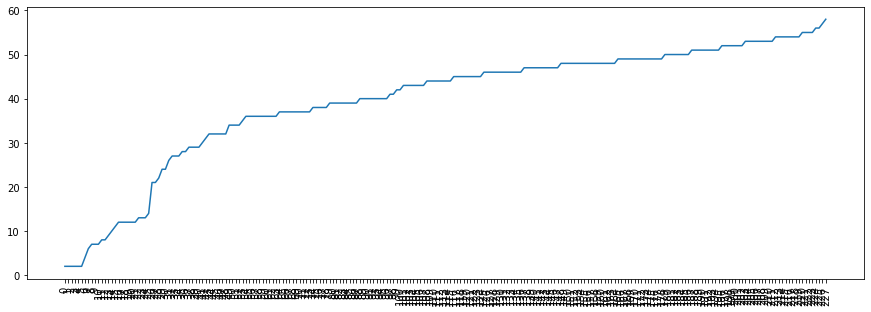

In [71]:
x = range(len(fits_files))
y = [len(overlap_dict[i]) for i in overlap_dict.keys()]

labels = [fits_files[X].split('/')[-1] for Y, X in sorted(zip(y,x), key=lambda pair: pair[0])]

#print(labels)

fig = plt.figure(figsize=(15,5))
plt.xticks(range(len(labels)), rotation=90)
plt.plot(x, sorted(y))

In [121]:
labels[-20:]

['P206+50_mosaic-blanked.fits',
 'P155+55_mosaic-blanked.fits',
 'P160+55_mosaic-blanked.fits',
 'P154+50_mosaic-blanked.fits',
 'P219+52_mosaic-blanked.fits',
 'P221+47_mosaic-blanked.fits',
 'P227+55_mosaic-blanked.fits',
 'P214+52_mosaic-blanked.fits',
 'P210+52_mosaic-blanked.fits',
 'P9Hetdex01_mosaic-blanked.fits',
 'P159+52_mosaic-blanked.fits',
 'P231+53_mosaic-blanked.fits',
 'P223+52_mosaic-blanked.fits',
 'P155+52_mosaic-blanked.fits',
 'P13Hetdex12_mosaic-blanked.fits',
 'P227+53_mosaic-blanked.fits',
 'P215+50_mosaic-blanked.fits',
 'P225+47_mosaic-blanked.fits',
 'P219+50_mosaic-blanked.fits',
 'P211+50_mosaic-blanked.fits']

In [122]:
labels[:20]

['P121+32_mosaic-blanked.fits',
 'P345+33_mosaic-blanked.fits',
 'P112+37_mosaic-blanked.fits',
 'P335+26_mosaic-blanked.fits',
 'P347+26_mosaic-blanked.fits',
 'P116+34_mosaic-blanked.fits',
 'P000+38_mosaic-blanked.fits',
 'P004+38_mosaic-blanked.fits',
 'P036+31_mosaic-blanked.fits',
 'P037+39_mosaic-blanked.fits',
 'P006+36_mosaic-blanked.fits',
 'P013+26_mosaic-blanked.fits',
 'P007+39_mosaic-blanked.fits',
 'P034+39_mosaic-blanked.fits',
 'P035+34_mosaic-blanked.fits',
 'P030+39_mosaic-blanked.fits',
 'P022+34_mosaic-blanked.fits',
 'P027+31_mosaic-blanked.fits',
 'P012+36_mosaic-blanked.fits',
 'P016+34_mosaic-blanked.fits']